# COCT Data Scientist Code Challenge

In [1]:
# Imports
import requests
import gzip
import shutil

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet

/home/claude/miniconda3/envs/coct/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Get Data
Download the data.

In [2]:
def download_file(url, filename):
    try:
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        response.raise_for_status()  # Raises an HTTPError for bad responses
        
        with open(filename, "wb") as file, tqdm(
            desc=filename,
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
                pbar.update(len(chunk))
        
        print(f"Downloaded: {filename}")
        return True
    
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return False
    
def uncompress_file(compressed_filename, uncompressed_filename):
    with gzip.open(compressed_filename, 'rb') as f_in:
        with open(uncompressed_filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    print(f"Uncompressed: {compressed_filename} to {uncompressed_filename}")
    return True

In [4]:
DATA_URL = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/sr_hex.csv.gz"
COMPRESSED_FILE_NAME = "sr_hex.csv.gz"
UNCOMPRESSED_FILE_NAME = "sr_hex.csv"

download_file(DATA_URL, COMPRESSED_FILE_NAME)

uncompress_file(COMPRESSED_FILE_NAME, UNCOMPRESSED_FILE_NAME)

sr_hex.csv.gz: 100%|██████████| 35.0M/35.0M [00:04<00:00, 7.77MB/s]


Downloaded: sr_hex.csv.gz
Uncompressed: sr_hex.csv.gz to sr_hex.csv


True

## Initial Data Exploration

In [4]:
# Load into Dataframe and print head
df = pd.read_csv('sr_hex.csv')
df.head()

,notification_number,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index
0,400583534,9.109492e+09,2020-10-07 06:55:18+02:00,2020-10-08 15:36:35+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area Central,District: Blaauwberg,TD Customer complaint groups,Pothole&Defect Road Foot Bic Way/Kerbs,Road (RCL),Wear and tear,MONTAGUE GARDENS,-33.872839,18.522488,88ad360225fffff
1,400555043,9.108995e+09,2020-07-09 16:08:13+02:00,2020-07-14 14:27:01+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area East,District : Somerset West,TD Customer complaint groups,Manhole Cover/Gully Grid,Road (RCL),Vandalism,SOMERSET WEST,-34.078916,18.848940,88ad36d5e1fffff
2,400589145,9.109614e+09,2020-10-27 10:21:59+02:00,2020-10-28 17:48:15+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area East,District : Somerset West,TD Customer complaint groups,Manhole Cover/Gully Grid,Road (RCL),Vandalism,STRAND,-34.102242,18.821116,88ad36d437fffff
3,400538915,9.108601e+09,2020-03-19 06:36:06+02:00,2021-03-29 20:34:19+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area North,District : Bellville,TD Customer complaint groups,Paint Markings Lines&Signs,Road Markings,Wear and tear,RAVENSMEAD,-33.920019,18.607209,88ad361133fffff
4,400568554,NaN,2020-08-25 09:48:42+02:00,2020-08-31 08:41:13+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area South,District : Athlone,TD Customer complaint groups,Pothole&Defect Road Foot Bic Way/Kerbs,Road (RCL),Surfacing failure,CLAREMONT,-33.987400,18.453760,88ad361709fffff


In [5]:
# Print DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941634 entries, 0 to 941633
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   notification_number   941634 non-null  int64  
 1   reference_number      592920 non-null  float64
 2   creation_timestamp    941634 non-null  object 
 3   completion_timestamp  929442 non-null  object 
 4   directorate           932199 non-null  object 
 5   department            932180 non-null  object 
 6   branch                913233 non-null  object 
 7   section               848509 non-null  object 
 8   code_group            941634 non-null  object 
 9   code                  941634 non-null  object 
 10  cause_code_group      131117 non-null  object 
 11  cause_code            129669 non-null  object 
 12  official_suburb       729221 non-null  object 
 13  latitude              729270 non-null  float64
 14  longitude             729270 non-null  float64
 15  

### Discussion
We see there are 941,634 entries in the dataset, with 16 data columns. 
Several columns contain null values (e.g. reference_number, completion_timestamp, cause_code_group).

### Group DF by Hex

Number of unique hex cells: 2083
Average number of service requests per hex: 452.06

Top 5 hex cells by number of service requests:
h3_level8_index
0                  212364
88ad3612a9fffff      3815
88ad361009fffff      3464
88ad368985fffff      3393
88ad361519fffff      2797
dtype: int64

Average number of service requests per hex (zero excluded): 350.27
Median of hex counts (zero excluded): 160.0
1st quartile of service requests per hex: 7.0
3rd quartile of service requests per hex: 533.25
Inter-quartile range of service requests per hex: 526.25


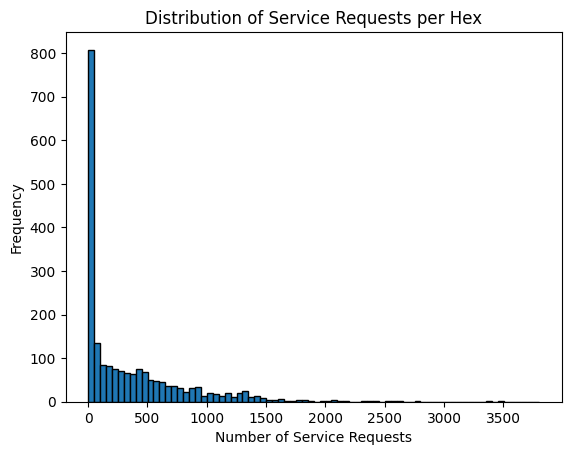

In [6]:
# Group by h3_level8_index and get basic statistics
hex_groups = df.groupby('h3_level8_index')

# Display basic information about the grouped data
print(f"Number of unique hex cells: {len(hex_groups)}")
print(f"Average number of service requests per hex: {len(df) / len(hex_groups):.2f}")

# Show first few groups with their counts
hex_counts = hex_groups.size().sort_values(ascending=False)
print("\nTop 5 hex cells by number of service requests:")
print(hex_counts.head(5))

# Drop the '0' hex cell
df_no_zero = df[df['h3_level8_index'] != '0']
hex_groups_no_zero = df_no_zero.groupby('h3_level8_index')
print(f"\nAverage number of service requests per hex (zero excluded): {len(df_no_zero) / len(hex_groups_no_zero):.2f}")

# Get Median service requests per hex
median_service_requests_per_hex = df_no_zero.groupby('h3_level8_index').size().median()
print(f"Median of hex counts (zero excluded): {median_service_requests_per_hex}")

# Get inter-quartile range of service requests per hex
q1_service_requests_per_hex = df_no_zero.groupby('h3_level8_index').size().quantile(0.25)
q3_service_requests_per_hex = df_no_zero.groupby('h3_level8_index').size().quantile(0.75)
iqr_service_requests_per_hex = q3_service_requests_per_hex - q1_service_requests_per_hex
print(f"1st quartile of service requests per hex: {q1_service_requests_per_hex}")
print(f"3rd quartile of service requests per hex: {q3_service_requests_per_hex}")
print(f"Inter-quartile range of service requests per hex: {iqr_service_requests_per_hex}")

# Get 1.5 * IQR


hex_counts_no_zero = hex_groups_no_zero.size().sort_values(ascending=False)

# Plot a histogram of the number of service requests per hex
plt.hist(hex_counts_no_zero, bins=range(1, max(hex_counts_no_zero) + 1, 50), edgecolor='black')
plt.title('Distribution of Service Requests per Hex')
plt.xlabel('Number of Service Requests')
plt.ylabel('Frequency')
plt.show()

### Discussion
There are 2083 unique hex cells. 
The most frequently occuring one is labled '0' and referse to service request that were not assigned a hex. 
The top 4 valid hex values have between 2797 and 3815 service requests.  
At first it seems on average a hex has 452 service requests.
But this is being skewed by the '0' hex. 
When we exclude the '0' hex we see the mean number of service requests per hex is actually 350 and the median is 160. 

### Lets focus on hexs that have sufficient data points

* We will focus on all hexes with more than the median number of service requests.
* We exclude the other hexes because we are concerned there are too few data points in the time series to fit an accurate model.
* We will then order the service requests in each hex by 'creation_timestamp' and aggregate by week to create a timeseries.

Median of hex counts (zero excluded): 160.0


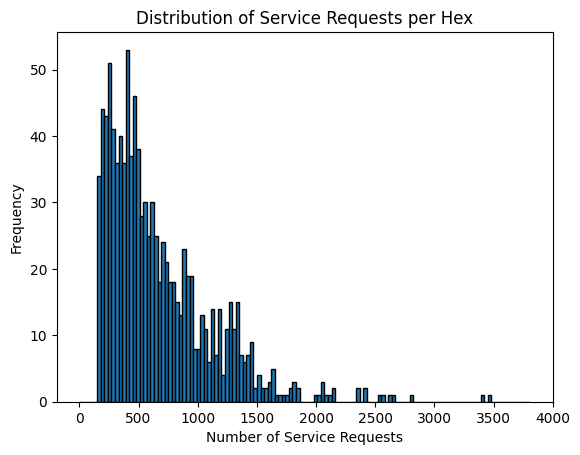

In [7]:
# Filter out hexes with less than the median number of service requests
df_no_zero = df[df['h3_level8_index'] != '0']
hex_groups_no_zero = df_no_zero.groupby('h3_level8_index')

# Get Median service requests per hex
median_service_requests_per_hex = df_no_zero.groupby('h3_level8_index').size().median()
print(f"Median of hex counts (zero excluded): {median_service_requests_per_hex}")

# Filter out hexes with less than the median number of service requests
hex_counts = df_no_zero.groupby('h3_level8_index').size()
hexes_above_median = hex_counts[hex_counts >= median_service_requests_per_hex].index
df_filtered = df_no_zero[df_no_zero['h3_level8_index'].isin(hexes_above_median)]
hex_groups_filtered = df_filtered.groupby('h3_level8_index')

# Validate by plotting histogram of service requests per hex
hex_groups_filtered_counts = hex_groups_filtered.size().sort_values(ascending=False)
plt.hist(hex_groups_filtered_counts, bins=range(1, max(hex_groups_filtered_counts) + 1, 30), edgecolor='black')
plt.title('Distribution of Service Requests per Hex')
plt.xlabel('Number of Service Requests')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Create timeseries for each hex by ordering by creation_timestamp
hex_timeseries = {}

for hex_id, group in hex_groups_filtered:
    # Sort by creation_timestamp to create timeseries
    sorted_group = group.sort_values('creation_timestamp')
    
    # Store the sorted dataframe for this hex
    hex_timeseries[hex_id] = sorted_group

# Display some information about the timeseries
print(f"Number of hexes with timeseries: {len(hex_timeseries)}")

# Show example of first few entries for a sample hex
sample_hex = list(hex_timeseries.keys())[0]
print(f"\nSample timeseries for hex: {sample_hex}")
print(f"Number of service requests: {len(hex_timeseries[sample_hex])}")
print(f"Time range: {hex_timeseries[sample_hex]['creation_timestamp'].min()} to {hex_timeseries[sample_hex]['creation_timestamp'].max()}")

# Display first few rows of the sample timeseries
print("\nFirst few entries:")
print(hex_timeseries[sample_hex][['creation_timestamp', 'code']].head(10))


Number of hexes with timeseries: 1041

Sample timeseries for hex: 88ad360001fffff
Number of service requests: 170
Time range: 2020-01-02 10:01:38+02:00 to 2020-12-22 19:58:22+02:00

First few entries:
              creation_timestamp                                    code
36397  2020-01-02 10:01:38+02:00                            No Water WMD
39076  2020-01-03 08:59:22+02:00              Non-Collection of 240L Bin
39387  2020-01-03 09:40:19+02:00                            No Water WMD
45720  2020-01-06 11:59:25+02:00                             OSL - Water
47043  2020-01-06 15:19:18+02:00                            No Water WMD
49247  2020-01-07 11:20:57+02:00  Restrictions: Quota Increase: Domestic
64380  2020-01-13 10:42:20+02:00   Maintenance of Property  Technical MD
67560  2020-01-14 09:47:32+02:00    Customer : Meter Reading/Consumption
68734  2020-01-14 12:34:07+02:00    Customer : Meter Reading/Consumption
74916  2020-01-16 09:47:15+02:00                      Bin Repairs - 2

In [9]:
# Aggregate by week for each hex
hex_weekly_aggregated = {}

for hex_id, timeseries in hex_timeseries.items():
    # Convert creation_timestamp to datetime if not already
    timeseries_copy = timeseries.copy()
    timeseries_copy['creation_timestamp'] = pd.to_datetime(timeseries_copy['creation_timestamp'])
    
    # Create week column (year-week format)
    timeseries_copy['year_week'] = timeseries_copy['creation_timestamp'].dt.strftime('%Y-%U')
    
    # Group by week and count service requests
    weekly_counts = timeseries_copy.groupby('year_week').size().reset_index(name='service_requests')
    
    # Create complete date range for this hex
    min_date = timeseries_copy['creation_timestamp'].min()
    max_date = timeseries_copy['creation_timestamp'].max()
    
    # Generate all weeks between min and max date
    date_range = pd.date_range(start=min_date, end=max_date, freq='W-MON')
    all_weeks = [date.strftime('%Y-%U') for date in date_range]
    
    # Create a complete dataframe with all weeks
    complete_weeks_df = pd.DataFrame({'year_week': all_weeks})
    
    # Merge with actual data, filling missing weeks with 0
    complete_weekly_counts = complete_weeks_df.merge(
        weekly_counts, on='year_week', how='left'
    ).fillna(0)
    
    # Convert service_requests to int
    complete_weekly_counts['service_requests'] = complete_weekly_counts['service_requests'].astype(int)
    
    # Store the weekly aggregated data for this hex
    hex_weekly_aggregated[hex_id] = complete_weekly_counts

# Display information about the weekly aggregation
print(f"Number of hexes with weekly aggregation: {len(hex_weekly_aggregated)}")

# Show example of weekly aggregation for the sample hex
sample_hex = list(hex_weekly_aggregated.keys())[0]
print(f"\nWeekly aggregation for hex: {sample_hex}")
print(f"Number of weeks with data: {len(hex_weekly_aggregated[sample_hex])}")
print("\nFirst few weeks:")
print(hex_weekly_aggregated[sample_hex].head(5))

# Show summary statistics across all hexes
all_weekly_counts = []
for hex_data in hex_weekly_aggregated.values():
    all_weekly_counts.extend(hex_data['service_requests'].tolist())

print(f"\nSummary statistics for weekly service requests across all hexes:")
print(f"Mean: {np.mean(all_weekly_counts):.2f}")
print(f"Median: {np.median(all_weekly_counts):.2f}")
print(f"Max: {np.max(all_weekly_counts)}")
print(f"Min: {np.min(all_weekly_counts)}")


Number of hexes with weekly aggregation: 1041

Weekly aggregation for hex: 88ad360001fffff
Number of weeks with data: 51

First few weeks:
  year_week  service_requests
0   2020-01                 3
1   2020-02                 4
2   2020-03                 3
3   2020-04                 1
4   2020-05                 4

Summary statistics for weekly service requests across all hexes:
Mean: 12.82
Median: 9.00
Max: 426
Min: 0


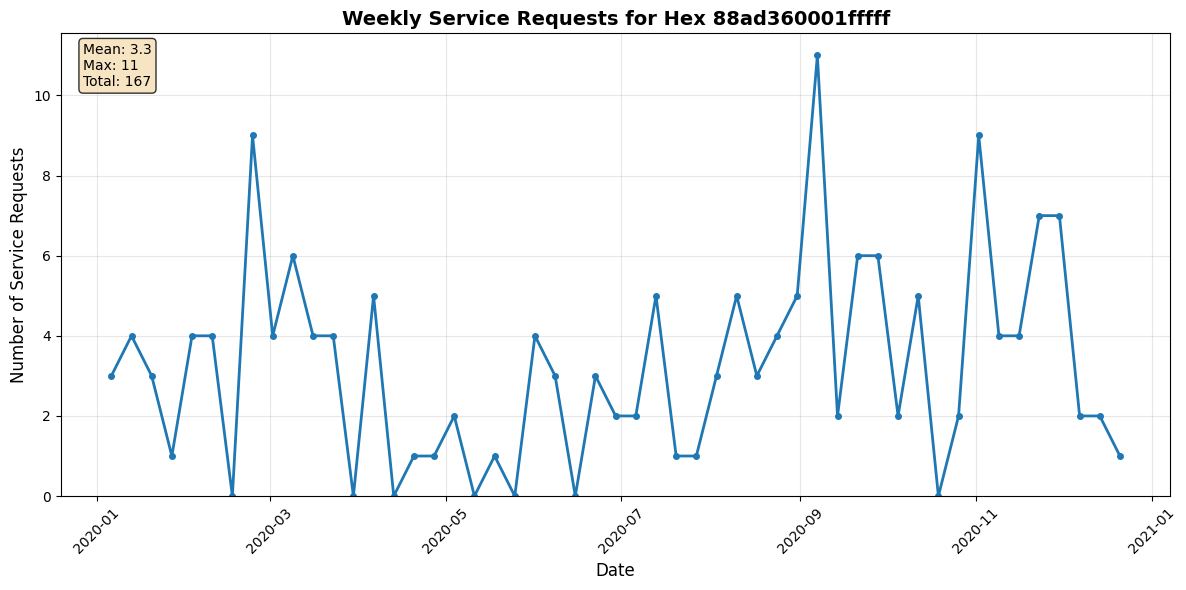

Hex 88ad360001fffff statistics:
Total weeks with data: 51
Mean weekly requests: 3.27
Max weekly requests: 11
Total requests: 167
Date range: 2020-01-06 to 2020-12-21


In [10]:
# Select a sample hex and plot its weekly timeseries
sample_hex = list(hex_weekly_aggregated.keys())[0]
hex_data = hex_weekly_aggregated[sample_hex]

# Convert year_week back to datetime for plotting
hex_data['date'] = pd.to_datetime(hex_data['year_week'] + '-1', format='%Y-%U-%w')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(hex_data['date'], hex_data['service_requests'], marker='o', linewidth=2, markersize=4)
plt.title(f'Weekly Service Requests for Hex {sample_hex}', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Service Requests', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.ylim(0)

# Add some statistics as text
mean_requests = hex_data['service_requests'].mean()
max_requests = hex_data['service_requests'].max()
total_requests = hex_data['service_requests'].sum()
plt.text(0.02, 0.98, f'Mean: {mean_requests:.1f}\nMax: {max_requests}\nTotal: {total_requests}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Hex {sample_hex} statistics:")
print(f"Total weeks with data: {len(hex_data)}")
print(f"Mean weekly requests: {mean_requests:.2f}")
print(f"Max weekly requests: {max_requests}")
print(f"Total requests: {total_requests}")
print(f"Date range: {hex_data['date'].min().strftime('%Y-%m-%d')} to {hex_data['date'].max().strftime('%Y-%m-%d')}")


### Fit a simple model
We will use Facebook's [Prophet model](https://facebook.github.io/prophet/docs/quick_start.html#python-api) to fit a timeseries model to the service request data for each hex.
Prophet works best with daily timeseries. So we will aggregate service requests by day. 


Number of hexes with daily aggregation: 1041

Daily aggregation for hex: 88ad360001fffff
Number of days with data: 356

First few days:
         date  service_requests
0  2020-01-02                 1
1  2020-01-03                 2
2  2020-01-04                 0
3  2020-01-05                 0
4  2020-01-06                 2


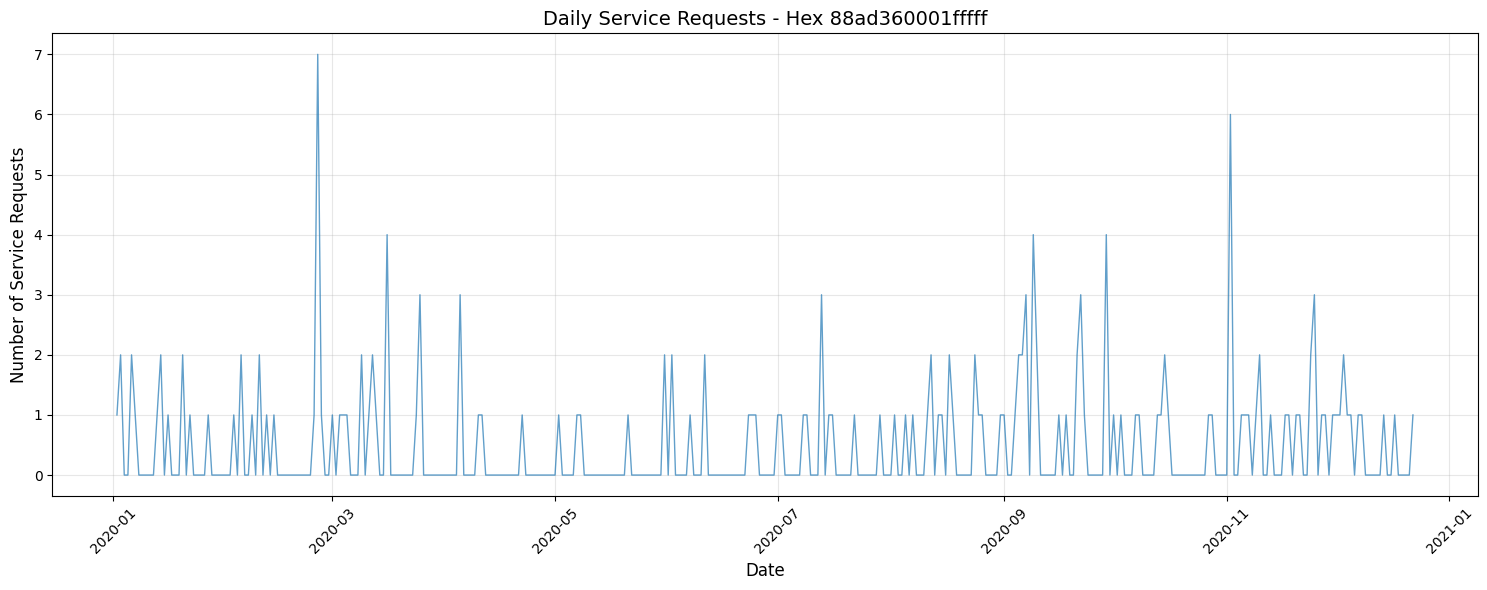

Total days: 356
Total service requests: 170
Average daily requests: 0.48
Max daily requests: 7
Min daily requests: 0


In [11]:

# Create daily aggregation for each hex
hex_daily_aggregated = {}

for hex_id, timeseries in hex_timeseries.items():
    # Convert creation_timestamp to datetime if not already
    timeseries_copy = timeseries.copy()
    timeseries_copy['creation_timestamp'] = pd.to_datetime(timeseries_copy['creation_timestamp'])
    
    # Create date column (date only, no time)
    timeseries_copy['date'] = timeseries_copy['creation_timestamp'].dt.date
    
    # Group by date and count service requests
    daily_counts = timeseries_copy.groupby('date').size().reset_index(name='service_requests')
    
    # Create complete date range for this hex
    min_date = timeseries_copy['creation_timestamp'].min().date()
    max_date = timeseries_copy['creation_timestamp'].max().date()
    
    # Generate all dates between min and max date
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    all_dates = [date.date() for date in date_range]
    
    # Create a complete dataframe with all dates
    complete_dates_df = pd.DataFrame({'date': all_dates})
    
    # Merge with actual data, filling missing dates with 0
    complete_daily_counts = complete_dates_df.merge(
        daily_counts, on='date', how='left'
    ).fillna(0)
    
    # Convert service_requests to int
    complete_daily_counts['service_requests'] = complete_daily_counts['service_requests'].astype(int)
    
    # Store the daily aggregated data for this hex
    hex_daily_aggregated[hex_id] = complete_daily_counts

# Display information about the daily aggregation
print(f"\nNumber of hexes with daily aggregation: {len(hex_daily_aggregated)}")

# Show example of daily aggregation for the sample hex
print(f"\nDaily aggregation for hex: {sample_hex}")
print(f"Number of days with data: {len(hex_daily_aggregated[sample_hex])}")
print("\nFirst few days:")
print(hex_daily_aggregated[sample_hex].head(5))

# Plot the daily time series for the sample hex
plt.figure(figsize=(15, 6))

# Get the daily data for the sample hex
daily_data = hex_daily_aggregated[sample_hex]

# Plot the time series
plt.plot(daily_data['date'], daily_data['service_requests'], linewidth=1, alpha=0.7)

plt.title(f'Daily Service Requests - Hex {sample_hex}', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Service Requests', fontsize=12)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

# Print some statistics
print(f"Total days: {len(daily_data)}")
print(f"Total service requests: {daily_data['service_requests'].sum()}")
print(f"Average daily requests: {daily_data['service_requests'].mean():.2f}")
print(f"Max daily requests: {daily_data['service_requests'].max()}")
print(f"Min daily requests: {daily_data['service_requests'].min()}")


09:41:50 - cmdstanpy - INFO - Chain [1] start processing
09:41:50 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
356 2020-12-23  0.704652   -0.348095    1.733092
357 2020-12-24  0.370954   -0.753730    1.449487
358 2020-12-25  0.234145   -0.729006    1.198744
359 2020-12-26  0.158546   -0.885290    1.152302
360 2020-12-27  0.163190   -0.964388    1.253852
361 2020-12-28  0.737662   -0.269522    1.781422
362 2020-12-29  0.606809   -0.472153    1.578235
363 2020-12-30  0.862239   -0.070801    1.907564
364 2020-12-31  0.536479   -0.463912    1.624566
365 2021-01-01  0.403444   -0.637685    1.473759
366 2021-01-02  0.327399   -0.729898    1.370304
367 2021-01-03  0.327410   -0.716215    1.382020
368 2021-01-04  0.893195   -0.087891    1.936631
369 2021-01-05  0.749826   -0.305260    1.705445
370 2021-01-06  0.989220   -0.093826    2.078161
371 2021-01-07  0.644294   -0.373320    1.650891
372 2021-01-08  0.489422   -0.506105    1.463862
373 2021-01-09  0.389381   -0.649547    1.495495
374 2021-01-10  0.363802   -0.682641    1.349923
375 2021-01-11  0.90

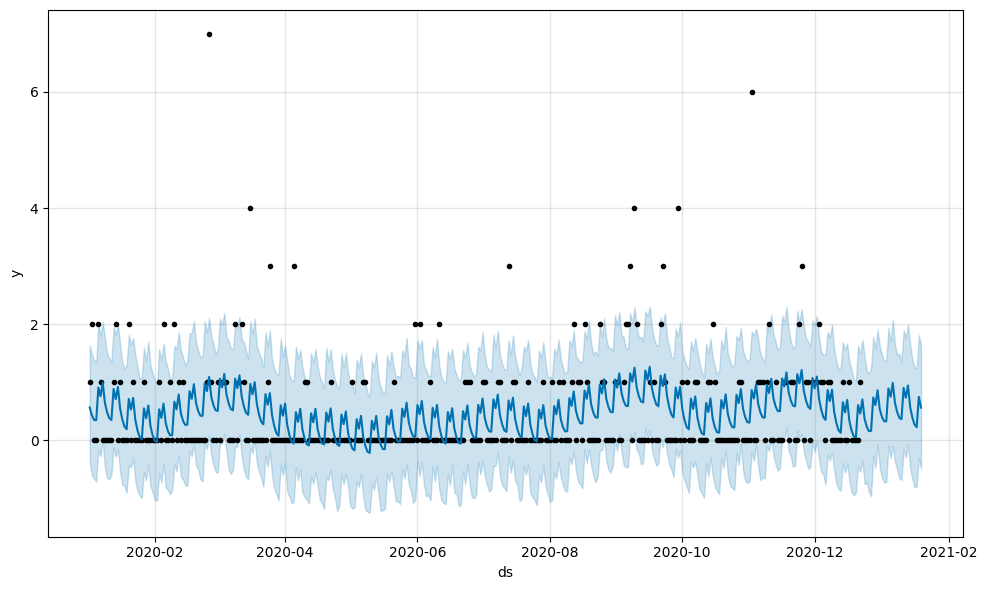

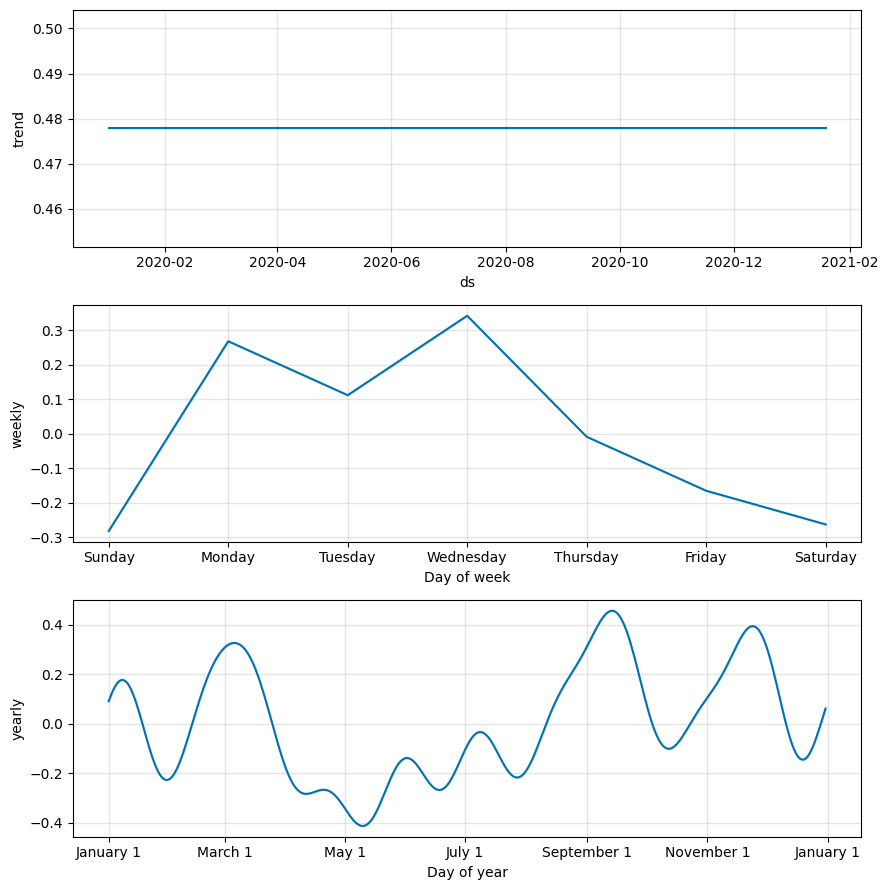

In [12]:
m = Prophet(growth="flat", yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

sample_hex = list(hex_daily_aggregated.keys())[0]
hex_data = hex_daily_aggregated[sample_hex]

# Rename columns to match Prophet requirements
hex_data = hex_data.rename(columns={'date': 'ds', 'service_requests': 'y'})

# Fit the model
m.fit(hex_data)

# Make predictions
future = m.make_future_dataframe(periods=28)
forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(28))

# Plot the daily forecast
fig = m.plot(forecast)

# Plot the weekly component of the forecast
from prophet.plot import plot_weekly, plot_components

w = m.plot_components(forecast)

### Discussion
From the model fit we can see two clear seasonality trends. One on the scale of days of the week. We see most service requests occure on a Wednesday, while very few are made on a weekend. Here the values are neggative, but that is an artefact of the model fit. We can just apply a floor operator at zero to correct for this.

# Compare fit to true data and predict 4 weeks after end of data
Here we aggregate the predicted values by prophet into weeks and compare the results to the true weekly aggregation. 
Further, we can use prophet to forcast the predicted number of service requests for the following 4 weeks. 

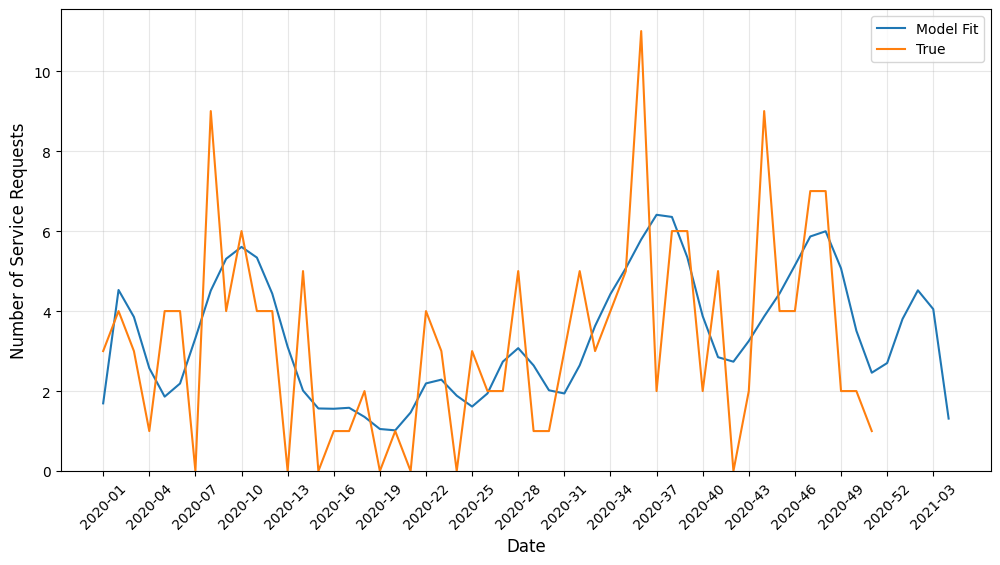

In [13]:
# Aggregate daily forecasts by week

# drop all the values except the ds and yhat columns - use .copy() to avoid SettingWithCopyWarning
weekly_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

# Clip yhats to be greater than 0 - use .loc[] for proper assignment
weekly_forecast.loc[:, 'yhat'] = weekly_forecast['yhat'].clip(lower=0)
weekly_forecast.loc[:, 'yhat_lower'] = weekly_forecast['yhat_lower'].clip(lower=0)
weekly_forecast.loc[:, 'yhat_upper'] = weekly_forecast['yhat_upper'].clip(lower=0)

# ensure 'ds' is datetime
weekly_forecast.loc[:, 'ds'] = pd.to_datetime(weekly_forecast['ds'])

# set the date as index
wf = weekly_forecast.set_index('ds')

# resample into calendar weeks (ending on Sundays by default) and sum
weekly = (
    wf[['yhat', 'yhat_lower', 'yhat_upper']]
    .resample('W')               # 'W' = weekly frequency, default label on Sunday
    .sum()
    .reset_index()
    .rename(columns={'yhat': 'weekly_yhat_sum', 'yhat_lower': 'weekly_yhat_lower', 'yhat_upper': 'weekly_yhat_upper'})
)

# convert weekly ds to year-week format
weekly['ds'] = weekly['ds'].dt.strftime('%Y-%U')

# True values 
true_weekly = hex_weekly_aggregated[sample_hex]
true_weekly = true_weekly.rename(columns={'year_week': 'ds', 'service_requests': 'y_true'})
true_weekly = true_weekly[["ds", "y_true"]]

# Add in the true values from hex_weekly_aggregated
weekly = weekly.merge(true_weekly, on='ds', how='left')

plt.figure(figsize=(12, 6))

# plot the weekly forecast
plt.plot(weekly['ds'], weekly['weekly_yhat_sum'], label='Model Fit')
# add upper and lower bounds to the plot as a shaded area
# plt.fill_between(weekly['ds'], weekly['weekly_yhat_lower'], weekly['weekly_yhat_upper'], color='gray', alpha=0.2)

# add true values to the plot
plt.plot(weekly['ds'], weekly['y_true'], label='True')


plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Service Requests', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
# Show fewer x-axis ticks by setting step size
plt.xticks(plt.xticks()[0][::3], plt.xticks()[1][::3], rotation=45)
plt.ylim(0)
plt.legend()

plt.show()

## Make a reusable function to do all of the above
Having walked through the process, we now make a function to do all of the above so that we can fit a model for any hex.

In [14]:
def fit_prophet_model_and_plot(hex_id, hex_daily_aggregated, hex_weekly_aggregated, 
                               forecast_periods=28, plot_results=True, figsize=(12, 6)):
    """
    Fit a Prophet model to a hex's daily service request data and plot weekly aggregated results.
    Returns the MSE, MAE, and forecast for the next 4 weeks.
    """
    
    # Check if hex exists in the data
    if hex_id not in hex_daily_aggregated:
        raise ValueError(f"Hex ID '{hex_id}' not found in hex_daily_aggregated")
    if hex_id not in hex_weekly_aggregated:
        raise ValueError(f"Hex ID '{hex_id}' not found in hex_weekly_aggregated")
    
    # Get the daily data for this hex
    hex_data = hex_daily_aggregated[hex_id].copy()
    
    # Rename columns to match Prophet requirements
    hex_data = hex_data.rename(columns={'date': 'ds', 'service_requests': 'y'})
    
    # Initialize and fit Prophet model
    model = Prophet(growth="flat", yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(hex_data)
    
    # Make predictions
    future = model.make_future_dataframe(periods=forecast_periods)
    forecast = model.predict(future)
    
    # Aggregate daily forecasts by week
    # Create a proper copy to avoid SettingWithCopyWarning
    weekly_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    
    # Clip yhats to be greater than 0 using .loc[] for proper assignment
    weekly_forecast.loc[:, 'yhat'] = weekly_forecast['yhat'].clip(lower=0)
    weekly_forecast.loc[:, 'yhat_lower'] = weekly_forecast['yhat_lower'].clip(lower=0)
    weekly_forecast.loc[:, 'yhat_upper'] = weekly_forecast['yhat_upper'].clip(lower=0)
    
    # Ensure 'ds' is datetime
    weekly_forecast.loc[:, 'ds'] = pd.to_datetime(weekly_forecast['ds'])
    
    # Set the date as index
    wf = weekly_forecast.set_index('ds')
    
    # Resample into calendar weeks (ending on Sundays by default) and sum
    weekly = (
        wf[['yhat', 'yhat_lower', 'yhat_upper']]
        .resample('W')  # 'W' = weekly frequency, default label on Sunday
        .sum()
        .reset_index()
        .rename(columns={
            'yhat': 'weekly_yhat_sum', 
            'yhat_lower': 'weekly_yhat_lower', 
            'yhat_upper': 'weekly_yhat_upper'
        })
    )
    
    # Convert weekly ds to year-week format
    weekly['ds'] = weekly['ds'].dt.strftime('%Y-%U')
    
    # Get true weekly values
    true_weekly = hex_weekly_aggregated[hex_id].copy()
    true_weekly = true_weekly.rename(columns={'year_week': 'ds', 'service_requests': 'y_true'})
    true_weekly = true_weekly[["ds", "y_true"]]
    
    # Merge with true values
    weekly_comparison = weekly.merge(true_weekly, on='ds', how='left')
    
    # Calculate error metrics (only for non-null true values)
    valid_comparison = weekly_comparison.dropna()
    if len(valid_comparison) > 0:
        mse = ((valid_comparison['weekly_yhat_sum'] - valid_comparison['y_true']) ** 2).mean()
        mae = abs(valid_comparison['weekly_yhat_sum'] - valid_comparison['y_true']).mean()
    else:
        mse = mae = float('nan')
    
    # Create plot if requested
    if plot_results:
        plt.figure(figsize=figsize)
        
        # Plot the weekly forecast
        plt.plot(weekly_comparison['ds'], weekly_comparison['weekly_yhat_sum'], 
                label='Model Fit', linewidth=2, alpha=0.8)
        
        # # Add confidence bounds as shaded area
        # plt.fill_between(weekly_comparison['ds'], 
        #                 weekly_comparison['weekly_yhat_lower'], 
        #                 weekly_comparison['weekly_yhat_upper'], 
        #                 color='blue', alpha=0.2, label='Confidence Interval')
        
        # Add true values to the plot
        plt.plot(weekly_comparison['ds'], weekly_comparison['y_true'], 
                label='True Values', linewidth=2, alpha=0.8, color='red')
        
        plt.title(f'Weekly Service Requests: Model vs True Values - Hex {hex_id}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Number of Service Requests', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        # Show fewer x-axis ticks by setting step size
        ax = plt.gca()
        ticks = ax.get_xticks()
        labels = ax.get_xticklabels()
        ax.set_xticks(ticks[::3])
        ax.set_xticklabels([label.get_text() for label in labels[::3]], rotation=45)
        
        plt.ylim(0)
        plt.legend()
        
        # Add error metrics as text
        plt.text(0.02, 0.98, f'MSE: {mse:.2f}\nMAE: {mae:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

        # Get last for 4 week forecast weekly_yhat
        forecast_week_1 = weekly_comparison['weekly_yhat_sum'].iloc[-4]
        forecast_week_2 = weekly_comparison['weekly_yhat_sum'].iloc[-3]
        forecast_week_3 = weekly_comparison['weekly_yhat_sum'].iloc[-2]
        forecast_week_4 = weekly_comparison['weekly_yhat_sum'].iloc[-1]
    
    # Return all results
    return {
        'mse': mse,
        'mae': mae,
        'forecast_week_1': forecast_week_1,
        'forecast_week_2': forecast_week_2,
        'forecast_week_3': forecast_week_3,
        'forecast_week_4': forecast_week_4,
    }


## Chose a hex and run
In the code below, choose a sample hex and run the cell.

09:46:30 - cmdstanpy - INFO - Chain [1] start processing
09:46:30 - cmdstanpy - INFO - Chain [1] done processing


Testing function with hex: 88ad36d545fffff


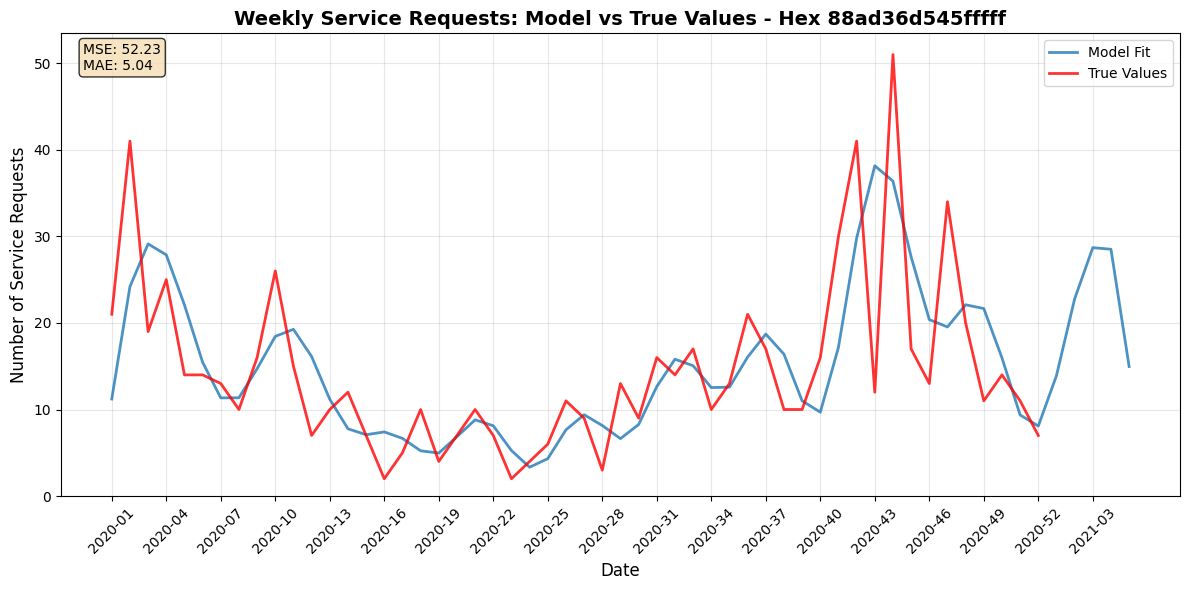

Model fit for 88ad36d545fffff: MSE = 52.23, MAE = 5.04
Forecast for 88ad36d545fffff: Week 1: 22.78, Week 2: 28.69, Week 3: 28.51, Week 4: 14.96


In [17]:
# Example usage - test with the first hex
sample_hex = list(hex_daily_aggregated.keys())[-42] # NOTE: choose a hex here

print(f"Testing function with hex: {sample_hex}")
result = fit_prophet_model_and_plot(sample_hex, hex_daily_aggregated, hex_weekly_aggregated)
print(f"Model fit for {sample_hex}: MSE = {result['mse']:.2f}, MAE = {result['mae']:.2f}")
print(f"Forecast for {sample_hex}: Week 1: {result['forecast_week_1']:.2f}, Week 2: {result['forecast_week_2']:.2f}, Week 3: {result['forecast_week_3']:.2f}, Week 4: {result['forecast_week_4']:.2f}")